## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train = train_data.copy()
test = test_data.copy()

In [4]:
def preprocessing(data):
    
    #Dropping null values
    data = data.dropna()
    
    #Dropping id
    data = data.drop('id', axis = 1)
    
    #Columns to get dummies
    cols = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']
    
    #Changing categories into dummies
    data_dum = pd.get_dummies(data = data , columns = cols, drop_first = True )
    
    #We don't need this column as it has almost no correlation with our dependent variable
    data_dum = data_dum.drop('Vintage', axis = 1)
    
    return data_dum

In [5]:
#Preprocessing training data
train_dum = preprocessing(train)

#Preprocessing test data
test_dum = preprocessing(test)

In [6]:
#Assigning inputs and targets

inputs = train_dum.drop('Response', axis = 1)
targets = train_dum['Response'] 

x_test = test_dum.copy()

#### We will use stratified K-Fold from sklearn as this is a highly imbalanced dataset

**Stratified K-Folds cross-validator. Provides train/test indices to split data in train/test sets. This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class. Parameters n_splitsint, default=5.**

In [7]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 10, random_state = None)

for train_idx, val_idx in skf.split(inputs, targets):
    x_train, x_val = inputs.iloc[train_idx], inputs.iloc[val_idx]
    y_train, y_val = targets.iloc[train_idx], targets.iloc[val_idx]

In [8]:
#Scaling all input data
    
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train_scaled = scaler.fit_transform(x_train)

#Will use only transform for validation and test data as we don't want any data leakage
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

### Model building

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

layer_size = inputs.shape[1]

initializer = tf.keras.initializers.HeNormal(seed=None)

#1st Layer
model.add(Dense(layer_size, activation='relu', kernel_initializer= initializer))
model.add(Dropout(0.5))

#2nd Layer
model.add(Dense(100, activation='relu', kernel_initializer = initializer)),
model.add(Dropout(0.5))

#3nd Layer
model.add(Dense(50, activation='relu', kernel_initializer = initializer)),
model.add(Dropout(0.5))

model.add(Dense(25, activation='relu', kernel_initializer = initializer)),
model.add(Dropout(0.5))

#Output layer
model.add(Dense(2, activation = 'softmax'))

In [10]:
#Learning rate decay
initial_rate = 0.1
decay_steps = 1.0
decay_rate = 0.6

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_rate, decay_steps, decay_rate)

adam = Adam(learning_rate = lr)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [11]:
#Training the model

early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights= True)

model.fit(
    
    x_train_scaled, 
    y_train,
    epochs = 100,
    batch_size = 128,
    callbacks = [early_stopping],
    validation_data = (x_val_scaled, y_val),
    verbose = 2,

)

Epoch 1/100
2680/2680 - 6s - loss: 0.3147 - accuracy: 0.8772 - val_loss: 0.2862 - val_accuracy: 0.8774
Epoch 2/100
2680/2680 - 7s - loss: 0.3057 - accuracy: 0.8774 - val_loss: 0.2860 - val_accuracy: 0.8774
Epoch 3/100
2680/2680 - 6s - loss: 0.3043 - accuracy: 0.8774 - val_loss: 0.2863 - val_accuracy: 0.8774
Epoch 4/100
2680/2680 - 6s - loss: 0.3023 - accuracy: 0.8774 - val_loss: 0.2861 - val_accuracy: 0.8774


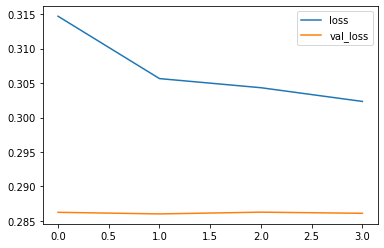

In [12]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [13]:
y_pred = model.predict_proba(x_test_scaled)[:,1]

Instructions for updating:
Please use `model.predict()` instead.


In [15]:
model.save('model.h5')

In [16]:
my_submission = pd.DataFrame({'id': test.id, 'Response': y_pred})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)
